In [2]:
import numpy as np
import torch
import os
import sys
from DispFormer.dataloader import *
from DispFormer.plots import *
from DispFormer.model.dispformer import *
from DispFormer.utils import *
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import cartopy.crs as ccrs


device = "cuda:0"
# Configuration settings
settings = {
    'training': {
        'batch_size'    : 256,
        'num_workers'   : 10
    }
}

######################################################
#                  Training Datasets
######################################################
# Paths for input data and saving the model
Shen2016_base_data_path     = "./Script/ModelDesign/datasets/Shen2016"
all_shen2016_data_path      = os.path.join(Shen2016_base_data_path,"period_phase_group.npz")
all_shen2016_label_path     = os.path.join(Shen2016_base_data_path,"depth_vs.npz")
# Paths for input data and saving the model
Shen2013_base_data_path     =  "./Script/ModelDesign/datasets/Shen2013"
all_shen2013_data_path      = os.path.join(Shen2013_base_data_path,"period_phase_group.npz")
all_shen2013_label_path     = os.path.join(Shen2013_base_data_path,"depth_vs.npz")

all_shen2016_dataset = DispersionDatasets(
    input_data_path =all_shen2016_data_path,
    input_label_path=all_shen2016_label_path,
    train=True,
    interp_layer=True,
    layer_thickness=0.5,
    layer_number=400,
    layer_used_range=[0, 400],
    augmentation_train_data=False,
    num_workers=settings['training']['num_workers']
)
all_shen2013_dataset = DispersionDatasets(
    input_data_path =all_shen2013_data_path,
    input_label_path=all_shen2013_label_path,
    train=True,
    interp_layer=True,
    layer_thickness=0.5,
    layer_number=400,
    layer_used_range=[0, 400],
    augmentation_train_data=False,
    num_workers=settings['training']['num_workers']
)

collect_fn = train_collate_fn

all_shen2016_loader = DataLoader(
    all_shen2016_dataset,
    batch_size  = settings['training']['batch_size'],
    shuffle     = False,
    collate_fn  = collect_fn,
    num_workers = settings['training']['num_workers']
)
all_shen2013_loader = DataLoader(
    all_shen2013_dataset,
    batch_size  = settings['training']['batch_size'],
    shuffle     = False,
    collate_fn  = collect_fn,
    num_workers = settings['training']['num_workers']
)

plot_base_path = "./Script/ModelDesign/test-zero-shot/Figures"

In [3]:
all_shen2013_disp_loc_path  = os.path.join(Shen2013_base_data_path,"depth_vs_loc.npz")
all_shen2013_target_vs_path = os.path.join(Shen2013_base_data_path,"depth_vs.npz")
all_shen2013_disp_loc       = np.load(all_shen2013_disp_loc_path)["data"]
all_shen2013_disp_loc[:,0]   = all_shen2013_disp_loc[:,0] - 360
all_shen2013_target_vs      = np.load(all_shen2013_target_vs_path)["data"] 

all_shen2016_disp_loc_path  = os.path.join(Shen2016_base_data_path,"depth_vs_loc.npz")
all_shen2016_target_vs_path = os.path.join(Shen2016_base_data_path,"depth_vs.npz")
all_shen2016_disp_loc       = np.load(all_shen2016_disp_loc_path)["data"]
all_shen2016_target_vs      = np.load(all_shen2016_target_vs_path)["data"] 

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# load the colormap from GMT
cpt_file = "./DispFormer/plot_source/GMT_panoply.cpt"
cmap = load_cpt(cpt_file,num_colors=20,reverse=True)

def plot_slice_comparation(depth,all_disp_loc,target_vs,inv_vs,cmap='jet_r',figsize=(12,4)):
    # Set font style and size
    plt.rcParams['font.family'] = 'Arial'  # Font family
    plt.rcParams['font.size'] = 12  # Font size

    fig, ax = plt.subplots(1, 3, figsize=figsize)  # Increase figure size

    # Determine color limits for the first two scatter plots
    vmin = min(np.min(target_vs[:, 1, depth]), np.min(inv_vs[:, depth]))*1000
    vmax = max(np.max(target_vs[:, 1, depth]), np.max(inv_vs[:, depth]))*1000

    # Scatter plot for target values
    scatter1 = ax[0].scatter(all_disp_loc[:, 0], all_disp_loc[:, 1], c=target_vs[:, 1, depth]*1000, s=10, cmap=cmap, edgecolor='k', linewidth=0.1, vmin=vmin, vmax=vmax)
    ax[0].set_title("Target", fontsize=14, fontweight='bold')
    ax[0].set_xlabel("Longitude", fontsize=14)
    ax[0].set_ylabel("Latitude", fontsize=14)
    # ax[0].set_aspect('equal')  # Set equal aspect ratio

    # Scatter plot for inverted values
    scatter2 = ax[1].scatter(all_disp_loc[:, 0], all_disp_loc[:, 1], c=inv_vs[:, depth]*1000, s=10, cmap=cmap, edgecolor='k', linewidth=0.1, vmin=vmin, vmax=vmax)
    ax[1].set_title("Inverted", fontsize=14, fontweight='bold')
    ax[1].set_xlabel("Longitude", fontsize=14)
    ax[1].set_yticks([])
    # ax[1].set_aspect('equal')  # Set equal aspect ratio

    # Scatter plot for differences
    scatter3 = ax[2].scatter(all_disp_loc[:, 0], all_disp_loc[:, 1], c=np.abs(inv_vs[:, depth] - target_vs[:, 1, depth])*1000, s=10, cmap='gray_r', edgecolor='k', linewidth=0.1)
    ax[2].set_title("Difference", fontsize=14, fontweight='bold')
    ax[2].set_xlabel("Longitude", fontsize=14)
    ax[2].set_yticks([])
    # ax[2].set_aspect('equal')  # Set equal aspect ratio

    # Create horizontal colorbars with adjusted length
    cbar1 = fig.colorbar(scatter1, ax=ax[0], orientation='horizontal', pad=0.2, label='Vs (m/s)'           , shrink=1)  # Adjust shrink
    cbar2 = fig.colorbar(scatter2, ax=ax[1], orientation='horizontal', pad=0.2, label='Vs (m/s)'           , shrink=1)  # Adjust shrink
    cbar3 = fig.colorbar(scatter3, ax=ax[2], orientation='horizontal', pad=0.2, label='Vs Difference (m/s)', shrink=1)  # Adjust shrink

    # plt.tight_layout()  # Automatically adjust subplots to fit
    plt.subplots_adjust(wspace = 0.01)
    plt.show()

In [5]:
def plot_single_station_cmp_res(disp_loc,inputs_disp,target_vs,Transformer_inv_vs,
                                sta_idx,depth_idx,
                                save_path="",show=True,cmap='jet_r'):
    ############################################################
    plt.figure(figsize=(12,10))
    plt.subplot(221)
    # Scatter plot for target values
    plt.scatter(disp_loc[:,0],disp_loc[:,1],c=target_vs[:, 1, depth_idx]*1000, s=10, cmap=cmap, edgecolor='k', linewidth=0.1)
    plt.scatter(disp_loc[sta_idx,0],disp_loc[sta_idx,1],s=60,facecolor=None,edgecolor='k',marker='v',label='select station')
    # plt.scatter(train_disp_loc[::sparse_num,0],train_disp_loc[::sparse_num,1],s=2,c='k',marker='.',label='training sets')
    plt.legend(fontsize =11,loc='upper left')
    # plt.title(f"depth:{depth_idx*0.5} km")
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.tick_params(labelsize=12)

    ############################################################
    mask = (inputs_disp[sta_idx,1,:]>0) + (inputs_disp[sta_idx,2,:]>0)
    t = inputs_disp[sta_idx,0,mask]
    # generated initial model
    phase_mask  = inputs_disp[sta_idx,1,:]>0
    phase_obs   = inputs_disp[sta_idx,1,:][phase_mask]
    thickness   = np.arange(target_vs[sta_idx,1,:].shape[0])*0.5
    init_thick,init_vp,init_vs,init_rho = gen_init_model(inputs_disp[sta_idx,0,phase_mask],phase_obs,thickness,area=True) 
    
    plt.subplot(222)
    plt.step(target_vs[sta_idx,1,:],target_vs[sta_idx,0,:]          ,where='post',c='k',linestyle='--',label="True")
    plt.step(init_vs,target_vs[sta_idx,0,:]          ,where='post',c='g',linestyle='-' ,label="Empirical")
    plt.step(Transformer_inv_vs[sta_idx,:],target_vs[sta_idx,0,:]   ,where='post',c='b',linestyle='-' ,label="Transformer")
    plt.legend(fontsize =12)
    plt.gca().invert_yaxis()
    plt.xlabel("S-wave velocity (km/s)", fontsize=12)
    plt.ylabel("Depth (km)", fontsize=12)
    plt.tick_params(labelsize=12)
    plt.grid()

    ###########################################################
    Transformer_depth,Transformer_vs = np.arange(Transformer_inv_vs.shape[1])*0.5,Transformer_inv_vs[sta_idx]
    Transformer_thickness,Transformer_vp,Transformer_vs,Transformer_rho= gen_model(depth=Transformer_depth,vs=Transformer_vs,area=True)
    Transformer_vel_model = np.hstack((Transformer_thickness.reshape(-1,1),Transformer_vp.reshape(-1,1),Transformer_vs.reshape(-1,1),Transformer_rho.reshape(-1,1)))
    Transformer_pd = PhaseDispersion(*Transformer_vel_model.T)
    Transformer_gd = GroupDispersion(*Transformer_vel_model.T)
    Transformer_phase_disp = [Transformer_pd(t, mode=i, wave="rayleigh") for i in range(1)]
    Transformer_group_disp = [Transformer_gd(t, mode=i, wave='rayleigh') for i in range(1)]
    
    Initial_vel_model = np.hstack((init_thick.reshape(-1,1),init_vp.reshape(-1,1),init_vs.reshape(-1,1),init_rho.reshape(-1,1)))
    Initial_pd = PhaseDispersion(*Initial_vel_model.T)
    Initial_gd = GroupDispersion(*Initial_vel_model.T)
    Initial_phase_disp = [Initial_pd(t, mode=i, wave="rayleigh") for i in range(1)]
    Initial_group_disp = [Initial_gd(t, mode=i, wave='rayleigh') for i in range(1)]

    plt.subplot(223)
    mask = inputs_disp[sta_idx,1,:]>0
    plt.scatter(inputs_disp[sta_idx,0,mask],inputs_disp[sta_idx,1,mask]             ,c='k',s=30,label='observed')
    plt.scatter(Initial_phase_disp[0].period,Initial_phase_disp[0].velocity         ,c='g',s=10,label='Empirical')
    plt.scatter(Transformer_phase_disp[0].period,Transformer_phase_disp[0].velocity ,c='b',s=10,label='Transformer')
    # plt.legend()
    plt.xlabel("Period (s)", fontsize=12)
    plt.ylabel("Phase velocity (km/s)", fontsize=12)
    plt.tick_params(labelsize=12)

    plt.subplot(224)
    mask = inputs_disp[sta_idx,2,:]>0
    plt.scatter(inputs_disp[sta_idx,0,mask],inputs_disp[sta_idx,2,mask]             ,c='k',s=30,label='observed')
    plt.scatter(Initial_group_disp[0].period,Initial_group_disp[0].velocity         ,c='g',s=10,label="Empirical")
    plt.scatter(Transformer_group_disp[0].period,Transformer_group_disp[0].velocity ,c='b',s=10,label="Transformer")
    # plt.legend()
    plt.xlabel("Period (s)", fontsize=12)
    plt.ylabel("Group velocity (km/s)", fontsize=12)
    plt.tick_params(labelsize=12)
    
    if not save_path == "":
        plt.savefig(save_path,bbox_inches='tight',dpi=300)
    
    if show == True:
        plt.show()
    else:
        plt.close()

## Shen 2016

In [6]:
depth_begin = 0
depth_end   = 400
criterion   = NMSE

In [7]:
finetune_settings = {
    'model': {
        'model_dim' : 128,
        'num_heads' : 8,
        'num_layers': 3,
        'output_dim': 400
    },
}
zeroshot_model = DispersionTransformer(
                    finetune_settings['model']['model_dim'],
                    finetune_settings['model']['num_heads'],
                    finetune_settings['model']['num_layers'],
                    finetune_settings['model']['output_dim'],
                    device=device
                ).to(device)

# phase and group
load_model_path = "./Script/ModelDesign/pre-training/model/transformer.pt"

Transformer_loaded_model = load_model(zeroshot_model, load_model_path, device=device).to(device)
target_vs, inv_vs, inputs_disp = predict_res_transformer(Transformer_loaded_model, criterion, all_shen2016_loader,device=device)

nmse_value  = NMSE_np(inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mse_value   = MSE_np( inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mae_value   = MAE_np( inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mape_value  = MAPE_np(inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])

nmse_value,mse_value,mae_value,mape_value

/ailab/group/groups/ai4earth/liufeng1/.conda/envs/ADinversion/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


(2449.1067, 12.513578869402409, 79.82762157917023, 2.003638446331024)

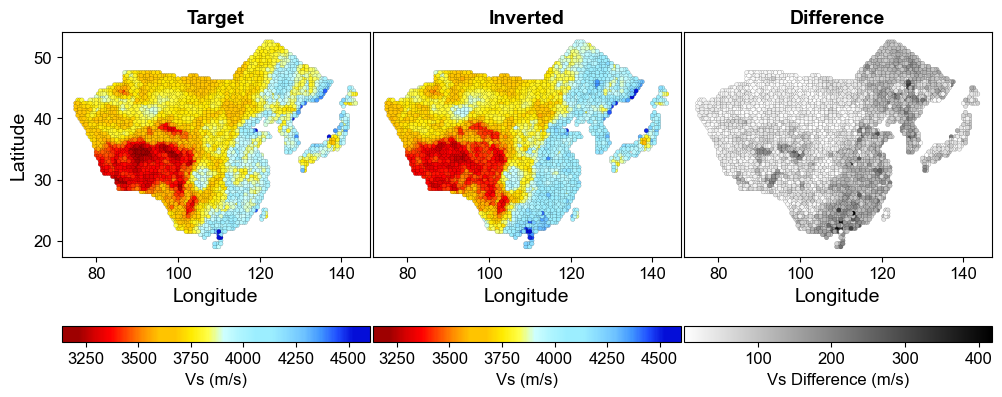

In [8]:
plot_slice_comparation(depth=60,all_disp_loc=all_shen2016_disp_loc,target_vs=target_vs,inv_vs=inv_vs,cmap=cmap,figsize=(12,4.5))

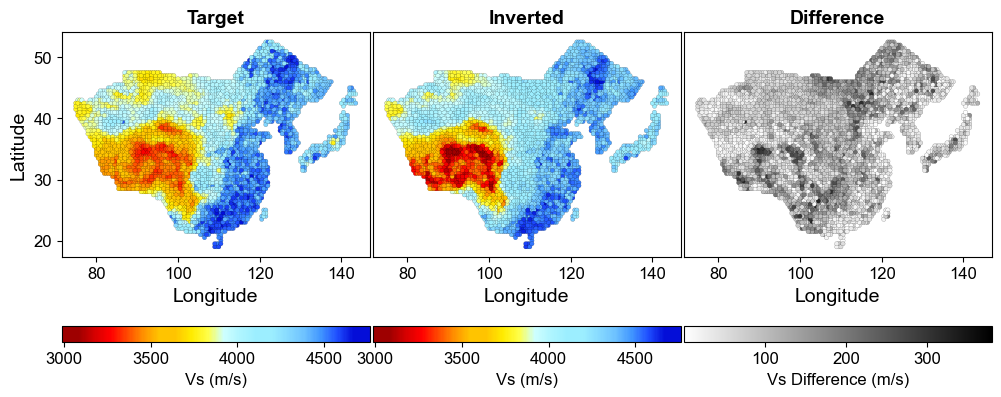

In [9]:
plot_slice_comparation(depth=80,all_disp_loc=all_shen2016_disp_loc,target_vs=target_vs,inv_vs=inv_vs,cmap=cmap,figsize=(12,4.5))

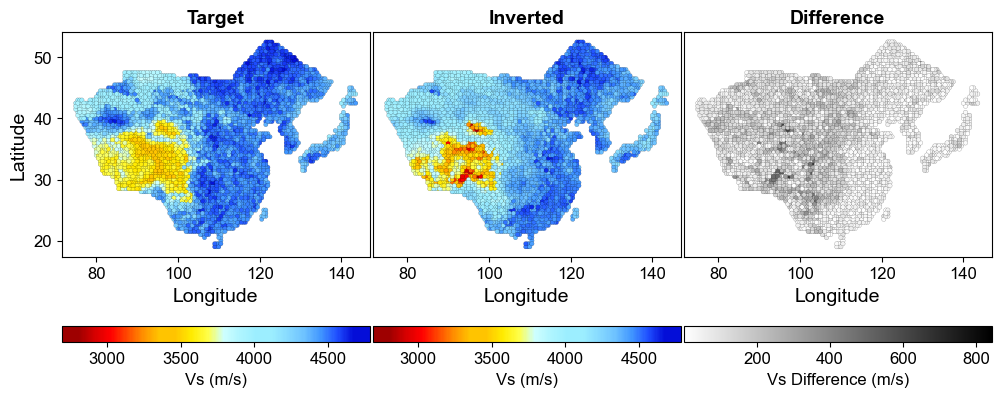

In [10]:
plot_slice_comparation(depth=100,all_disp_loc=all_shen2016_disp_loc,target_vs=target_vs,inv_vs=inv_vs,cmap=cmap,figsize=(12,4.5))

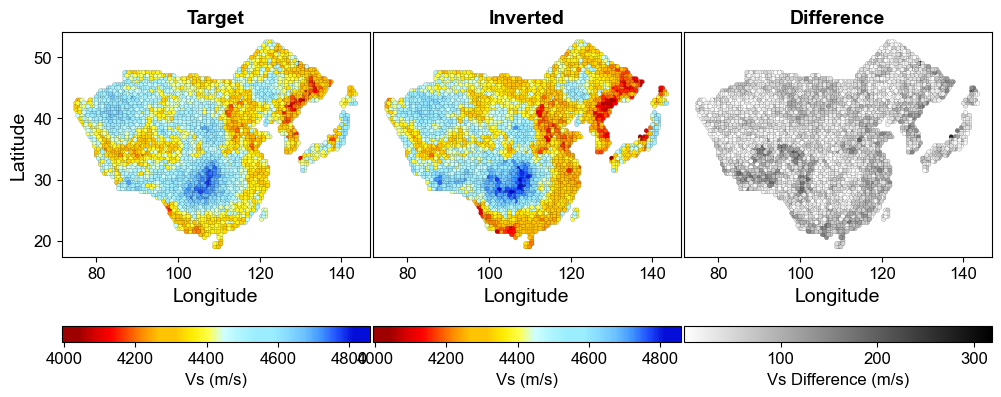

In [11]:
plot_slice_comparation(depth=240,all_disp_loc=all_shen2016_disp_loc,target_vs=target_vs,inv_vs=inv_vs,cmap=cmap,figsize=(12,4.5))

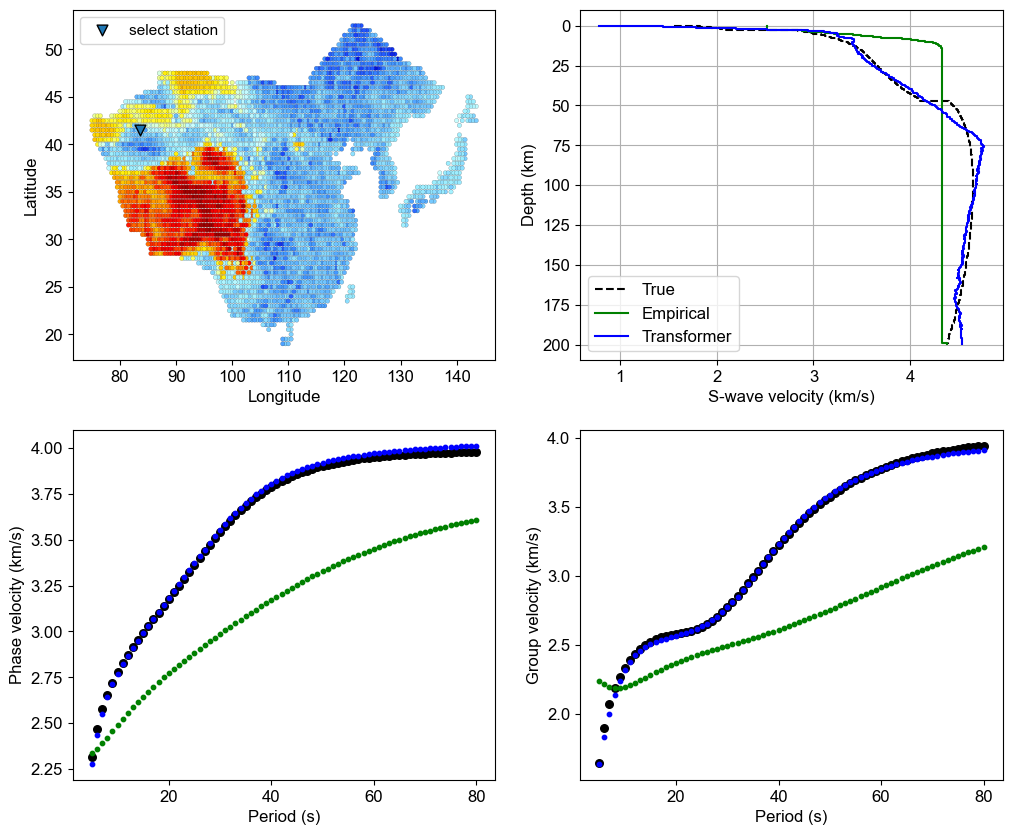

In [12]:
show        = True
sta_idx     = 2
depth_idx   = 100
plot_single_station_cmp_res(all_shen2016_disp_loc,inputs_disp,
                            target_vs,inv_vs,
                            sta_idx,depth_idx,
                            show=show,cmap=cmap)

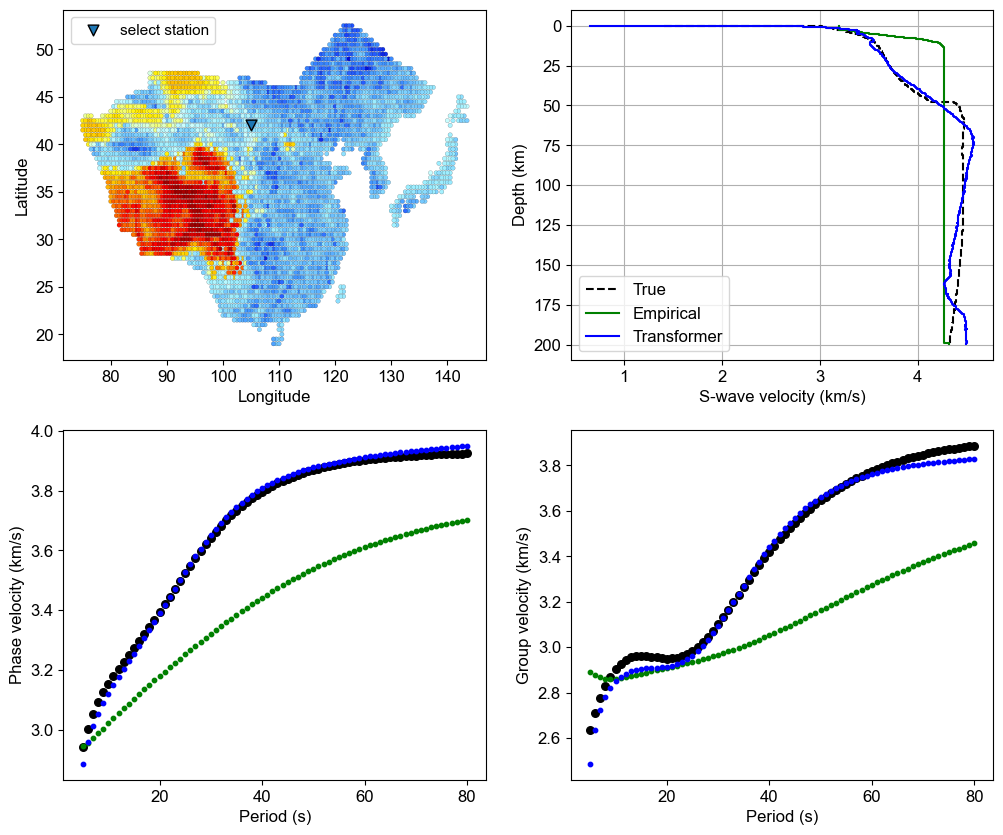

In [13]:
show        = True
sta_idx     = 10
depth_idx   = 100
plot_single_station_cmp_res(all_shen2016_disp_loc,inputs_disp,
                            target_vs,inv_vs,
                            sta_idx,depth_idx,
                            show=show,cmap=cmap)

## Shen 2013

In [14]:
depth_begin = 0
depth_end   = 300

In [15]:

finetune_settings = {
    'model': {
        'model_dim' : 128,
        'num_heads' : 8,
        'num_layers': 3,
        'output_dim': 400
    },
}
zeroshot_model = DispersionTransformer(
                    finetune_settings['model']['model_dim'],
                    finetune_settings['model']['num_heads'],
                    finetune_settings['model']['num_layers'],
                    finetune_settings['model']['output_dim'],
                    device=device
                ).to(device)

# phase and group
load_model_path = "./Script/ModelDesign/pre-training/model/transformer.pt"

Transformer_loaded_model        = load_model(zeroshot_model, load_model_path, device=device).to(device)
target_vs, inv_vs, inputs_disp = predict_res_transformer(Transformer_loaded_model, criterion, all_shen2013_loader,device=device)

nmse_value  = NMSE_np(inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mse_value   = MSE_np( inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mae_value   = MAE_np( inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
nape_value  = MAPE_np(inv_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])

nmse_value,mse_value,mae_value,mape_value

(5112.2188, 14.011952094733715, 72.78246432542801, 2.003638446331024)

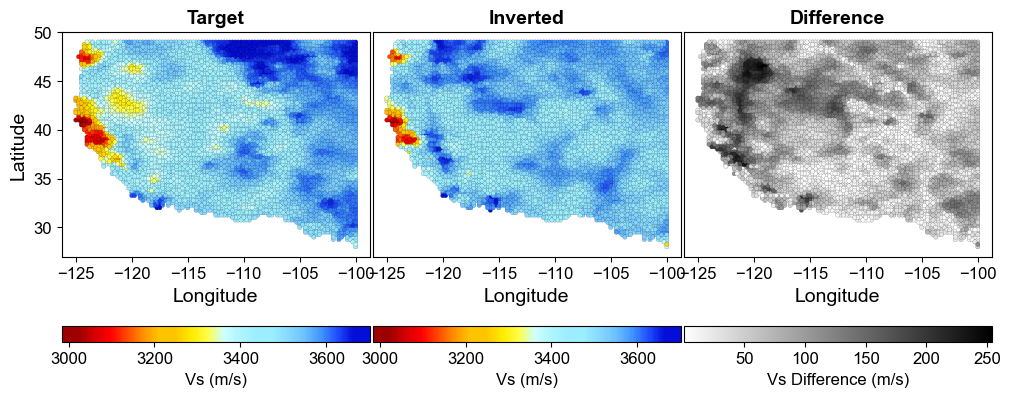

In [16]:
plot_slice_comparation(depth=20,all_disp_loc=all_shen2013_disp_loc,target_vs=target_vs,inv_vs=inv_vs,cmap=cmap,figsize=(12,4.5))

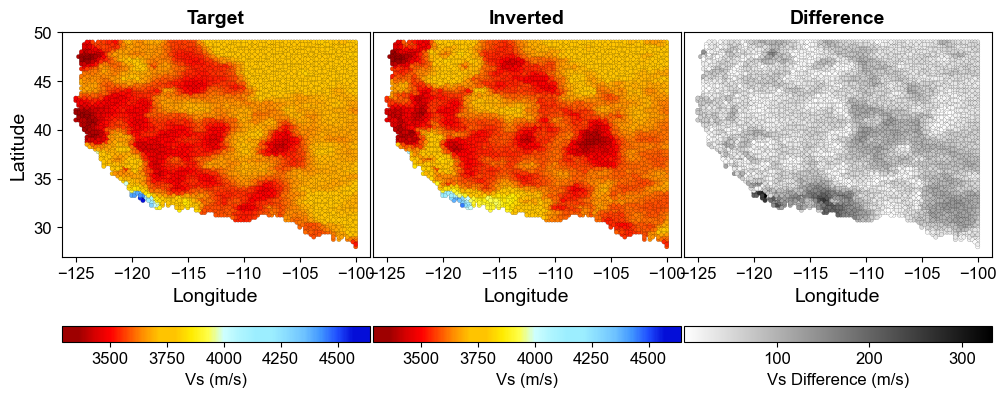

In [17]:
plot_slice_comparation(depth=40,all_disp_loc=all_shen2013_disp_loc,target_vs=target_vs,inv_vs=inv_vs,cmap=cmap,figsize=(12,4.5))

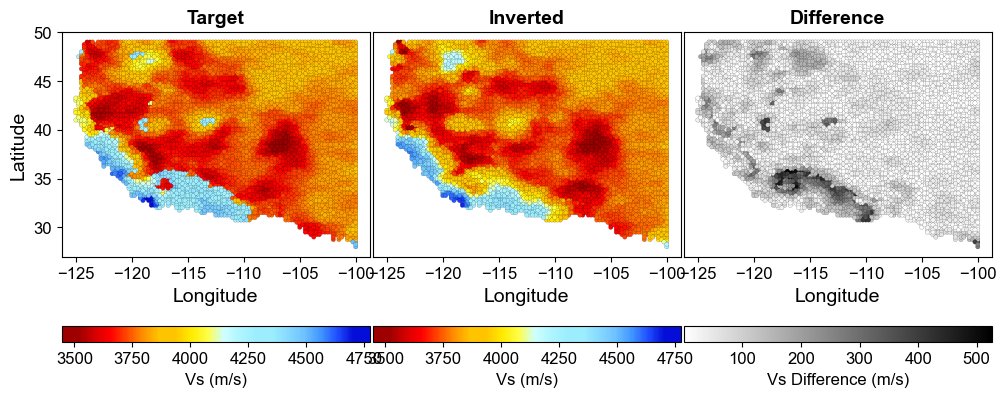

In [18]:
plot_slice_comparation(depth=60,all_disp_loc=all_shen2013_disp_loc,target_vs=target_vs,inv_vs=inv_vs,cmap=cmap,figsize=(12,4.5))

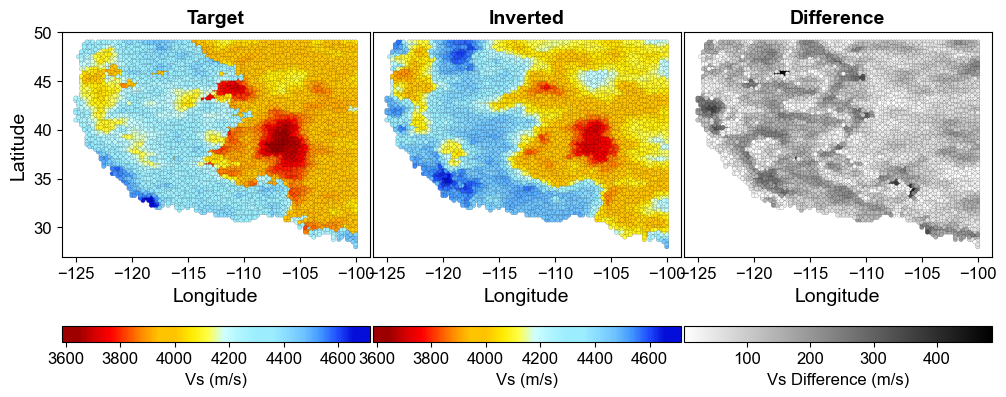

In [19]:
plot_slice_comparation(depth=80,all_disp_loc=all_shen2013_disp_loc,target_vs=target_vs,inv_vs=inv_vs,cmap=cmap,figsize=(12,4.5))

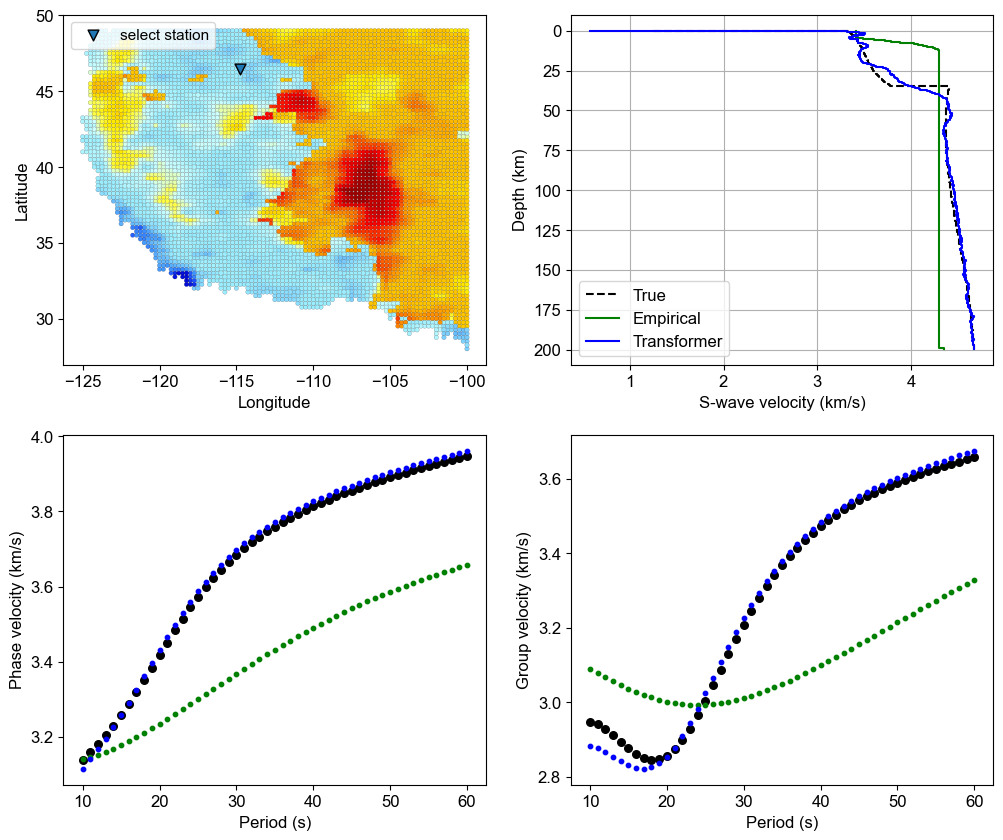

In [20]:
show = True
sta_idx     = 15
depth_idx   = 80
plot_single_station_cmp_res(all_shen2013_disp_loc,inputs_disp,
                            target_vs,inv_vs,
                            sta_idx,depth_idx,
                            show=show,cmap=cmap)

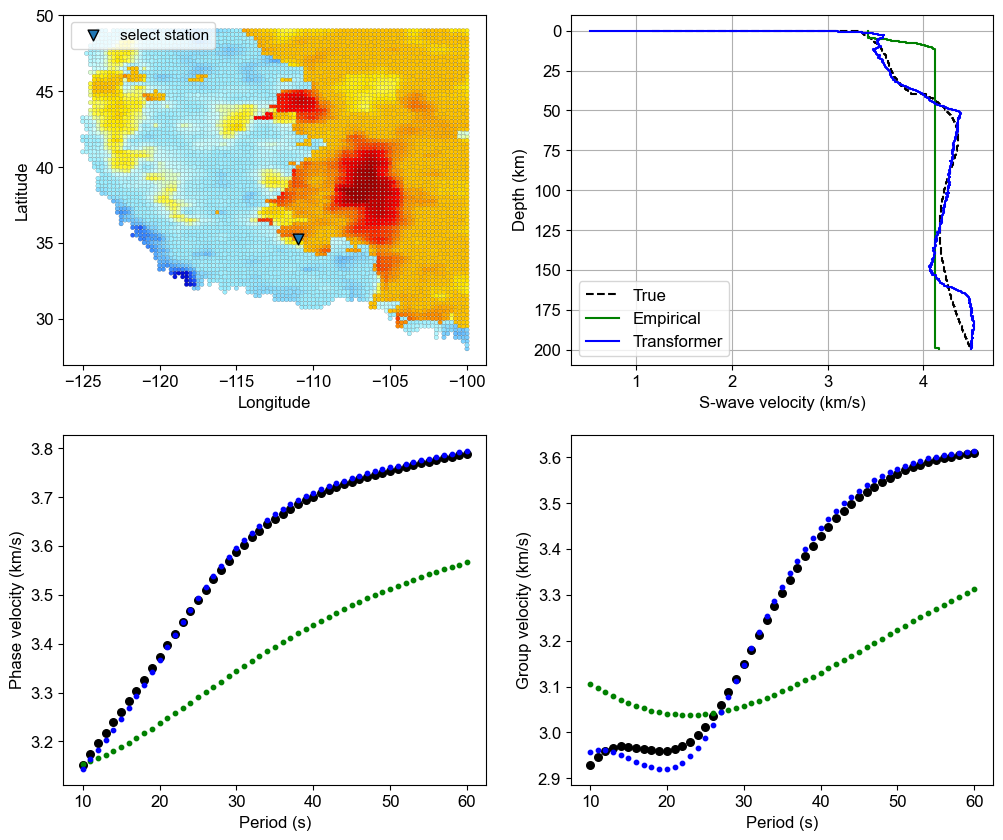

In [21]:
show = True
sta_idx     = 20
depth_idx   = 80
plot_single_station_cmp_res(all_shen2013_disp_loc,inputs_disp,
                            target_vs,inv_vs,
                            sta_idx,depth_idx,
                            show=show,cmap=cmap)

## Interped LITHO1.0

In [23]:
# load the Litho1.0 dataset
LITHO1_disp_loc_path  = "./Script/ModelDesign/datasets/LITHO1.0/lat_glat_lon.npz"
LITHO1_target_vs_path = "./Script/ModelDesign/datasets/LITHO1.0/depth_vs.npz"
LITHO1_disp_loc = np.load(LITHO1_disp_loc_path)["data"]
LITHO1_target_vs = np.load(LITHO1_target_vs_path)["data"]
LITHO1_lat = LITHO1_disp_loc[:, 0]
LITHO1_lon = LITHO1_disp_loc[:, 2]

# load the vs
LITHO1_vs = LITHO1_target_vs[:, :, 1]

# regional location
Shen2013_lon = all_shen2013_disp_loc[:, 0]
Shen2013_lat = all_shen2013_disp_loc[:, 1]
Shen2016_lon = all_shen2016_disp_loc[:, 0]
Shen2016_lat = all_shen2016_disp_loc[:, 1]

# interpolation
LITHO1_points = np.array([LITHO1_lat, LITHO1_lon]).T

# interpolation for each layer
Shen2016_interpolated_vs = []
Shen2013_interpolated_vs = []

if os.path.exists("./Script/ModelDesign/test-zero-shot/datasets/Shen2013_interpolated_vs.npz"):
    Shen2013_interpolated_vs    = np.load("./Script/ModelDesign/test-zero-shot/datasets/Shen2013_interpolated_vs.npz")["data"]
    all_shen2013_disp_loc       = np.load("./Script/ModelDesign/test-zero-shot/datasets/Shen2013_loc.npz")["data"]
    Shen2016_interpolated_vs    = np.load("./Script/ModelDesign/test-zero-shot/datasets/Shen2016_interpolated_vs.npz")["data"]
    all_shen2016_disp_loc       = np.load("./Script/ModelDesign/test-zero-shot/datasets/Shen2016_loc.npz")["data"]
else:
    for depth_idx in tqdm(range(LITHO1_vs.shape[1])):
        # extract the velcoity at i-th layer
        LITHO1_vs_at_depth = LITHO1_vs[:, depth_idx]
        
        # interpolation at the location of Shen2016&Shen2013
        Shen2013_interpolated_vs_at_depth = griddata(LITHO1_points, LITHO1_vs_at_depth, 
                                            (Shen2013_lat, Shen2013_lon), method='linear')
        Shen2016_interpolated_vs_at_depth = griddata(LITHO1_points, LITHO1_vs_at_depth, 
                                            (Shen2016_lat, Shen2016_lon), method='linear')
        Shen2013_interpolated_vs.append(Shen2013_interpolated_vs_at_depth)
        Shen2016_interpolated_vs.append(Shen2016_interpolated_vs_at_depth)

    Shen2013_interpolated_vs = np.array(Shen2013_interpolated_vs).T 
    Shen2016_interpolated_vs = np.array(Shen2016_interpolated_vs).T 

    np.savez("./Script/ModelDesign/test-zero-shot/datasets/Shen2013_interpolated_vs.npz",data=Shen2013_interpolated_vs)
    np.savez("./Script/ModelDesign/test-zero-shot/datasets/Shen2013_loc.npz",data=all_shen2013_disp_loc)
    np.savez("./Script/ModelDesign/test-zero-shot/datasets/Shen2016_interpolated_vs.npz",data=Shen2016_interpolated_vs)
    np.savez("./Script/ModelDesign/test-zero-shot/datasets/Shen2016_loc.npz",data=all_shen2016_disp_loc)

Shen2013_interpolated_vs.shape,Shen2016_interpolated_vs.shape

((6803, 400), (4516, 400))

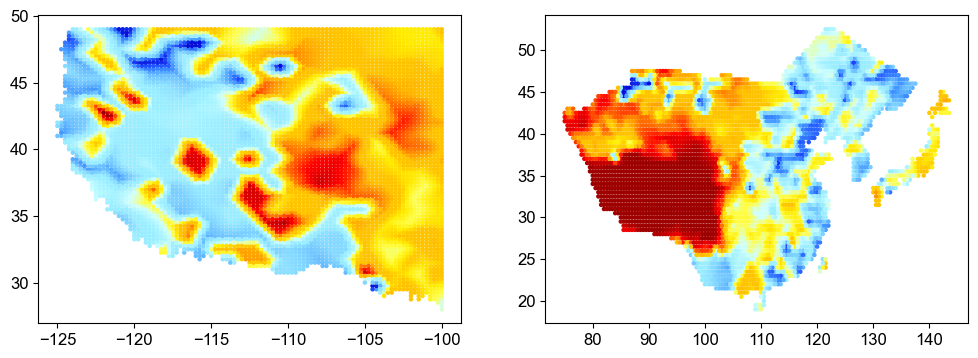

In [24]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].scatter(Shen2013_lon,Shen2013_lat,c=Shen2013_interpolated_vs[:,100],cmap=cmap,s=5)
axs[1].scatter(Shen2016_lon,Shen2016_lat,c=Shen2016_interpolated_vs[:,100],cmap=cmap,s=5)
plt.show()

In [25]:
depth_begin = 0
depth_end   = 400

Transformer_loaded_model        = load_model(zeroshot_model, load_model_path, device=device).to(device)
target_vs, inv_vs, inputs_disp  = predict_res_transformer(Transformer_loaded_model, criterion, all_shen2016_loader,device=device)

nmse_value  = NMSE_np(Shen2016_interpolated_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mse_value   = MSE_np( Shen2016_interpolated_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mae_value   = MAE_np( Shen2016_interpolated_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mape_value  = MAPE_np(Shen2016_interpolated_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])

nmse_value,mse_value,mae_value,mape_value

(19289.226859069684, 127.52487560618216, 233.610024668302, 5.960110602352394)

In [26]:
depth_begin = 0
depth_end   = 300

Transformer_loaded_model        = load_model(zeroshot_model, load_model_path, device=device).to(device)
target_vs, inv_vs, inputs_disp = predict_res_transformer(Transformer_loaded_model, criterion, all_shen2013_loader,device=device)

nmse_value  = NMSE_np(Shen2013_interpolated_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mse_value   = MSE_np( Shen2013_interpolated_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mae_value   = MAE_np( Shen2013_interpolated_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mape_value  = MAPE_np(Shen2013_interpolated_vs[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])

nmse_value,mse_value,mae_value,mape_value

(23622.183639424118, 128.6435777912894, 234.53204803646662, 6.1081542693624415)

## Data Distriubution comparation

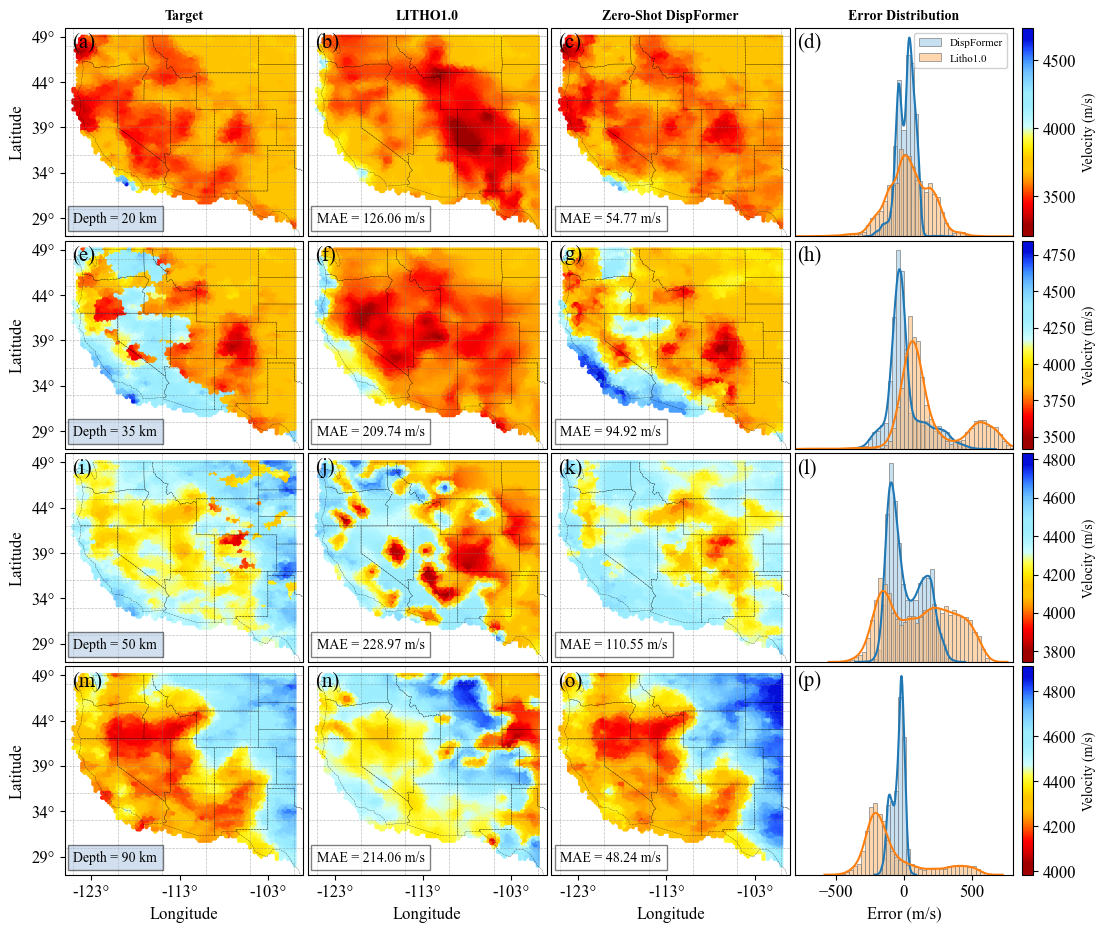

In [27]:
# Set the font globally to Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'

# Load custom shapefile for coastlines
custom_shapefile_path = "./DispFormer/plot_source/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"
coastline_feature = ShapelyFeature(Reader(custom_shapefile_path).geometries(), ccrs.PlateCarree())

def plot_rows(axs, row, depth_idx, last_row=False):
    vmin = np.min(target_vs_2013[:, 1, depth_idx] * 1000-100)
    vmax = np.max(target_vs_2013[:, 1, depth_idx] * 1000+100)
    
    # Scatter plots for target and inverted velocities
    sc_target = axs[row][0].scatter(all_shen2013_disp_loc[:, 0], all_shen2013_disp_loc[:, 1],
                        c=target_vs_2013[:, 1, depth_idx] * 1000, cmap=cmap, s=10, vmin=vmin, vmax=vmax, edgecolor='None', alpha=1)
    litho1_init= axs[row][1].scatter(all_shen2013_disp_loc[:, 0], all_shen2013_disp_loc[:, 1],
                        c=Shen2013_interpolated_vs[:, depth_idx] * 1000, cmap=cmap, s=10, vmin=vmin, vmax=vmax, edgecolor='None', alpha=1)
    sc_inv     = axs[row][2].scatter(all_shen2013_disp_loc[:, 0], all_shen2013_disp_loc[:, 1],
                        c=inv_vs_2013[:, depth_idx] * 1000, cmap=cmap, s=10, vmin=vmin, vmax=vmax, edgecolor='None', alpha=1)

    # Add longitude/latitude gridline and coastline feature
    for ax in axs[row][:3]:
        gl0 = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl0.top_labels      = False  # Disable top labels
        gl0.right_labels    = False  # Disable right labels
        gl0.left_labels     = False
        gl0.bottom_labels   = False
        gl0.xlabel_style    = {'size': 8, 'color': 'black'}  # Customize label style
        gl0.ylabel_style    = {'size': 8, 'color': 'black'}  # Customize label style
        
        ax.add_feature(coastline_feature, edgecolor='black', facecolor='None', linewidth=0.2, linestyle='-.')
        
        # Set extent for automatic ticks
        extent = [all_shen2013_disp_loc[:, 0].min() - 1, all_shen2013_disp_loc[:, 0].max() + 1,
                  all_shen2013_disp_loc[:, 1].min() - 1, all_shen2013_disp_loc[:, 1].max() + 1]
        ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Annotation for depth
    axs[row][0].annotate(f"Depth = {int(depth_idx * 0.5)} km",
                         xy=(all_shen2013_disp_loc[:, 0].min(), all_shen2013_disp_loc[:, 1].min() + 0.5),
                         xycoords='data', fontsize=10, color='black',
                         bbox=dict(facecolor='#A7C0DE', alpha=0.5, edgecolor='black'))
    
    # Compute MAE and annotate
    mae = np.mean(np.abs(target_vs_2013[:, 1, depth_idx] - Shen2013_interpolated_vs[:, depth_idx])) * 1000  # Convert to km
    axs[row][1].annotate(f"MAE = {mae:.2f} m/s",
                         xy=(all_shen2013_disp_loc[:, 0].min(), all_shen2013_disp_loc[:, 1].min() + 0.5),
                         xycoords='data', fontsize=10, color='black',
                         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
    
    # Compute MAE and annotate
    mae = np.mean(np.abs(target_vs_2013[:, 1, depth_idx] - inv_vs_2013[:, depth_idx])) * 1000  # Convert to km
    axs[row][2].annotate(f"MAE = {mae:.2f} m/s",
                         xy=(all_shen2013_disp_loc[:, 0].min(), all_shen2013_disp_loc[:, 1].min() + 0.5),
                         xycoords='data', fontsize=10, color='black',
                         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    # Set latitude and longitude ticks
    x_ticks_begin_shift = 2
    y_ticks_begin_shift = 1
    x_ticks_interval    = 10
    y_ticks_interval    = 5
    axs[row][0].set_yticks(np.arange(np.floor(all_shen2013_disp_loc[:, 1].min()) + y_ticks_begin_shift,
                                     np.ceil(all_shen2013_disp_loc[:, 1].max()) + 1, y_ticks_interval),
                                     crs=ccrs.PlateCarree())
    axs[row][0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))

    if last_row:
        for ax in axs[row][:3]:
            ax.set_xticks(np.arange(np.floor(all_shen2013_disp_loc[:, 0].min()) + x_ticks_begin_shift,
                                    np.ceil(all_shen2013_disp_loc[:, 0].max()), x_ticks_interval),
                                    crs=ccrs.PlateCarree())
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
            ax.set_xlabel("Longitude")
    axs[row][0].set_ylabel("Latitude")
    
    for ax in axs[row][:3]:
        ax.set_aspect('auto')
    for ax in axs[row]:
        ax.tick_params(labelsize=12)
    
    ###############################################################################################################
    # Calculate absolute errors
    errors_inv = (target_vs_2013[:, 1, depth_idx] - inv_vs_2013[:, depth_idx]) * 1000

    # Set bin width
    bin_width = 30
    inv_bins = np.arange(min(errors_inv), max(errors_inv) + bin_width, bin_width)

    # Plot histogram for INV errors
    sns.histplot(errors_inv, bins=inv_bins, color='#A0CBE8', kde=False, ax=axs[row][3], stat="density", 
                alpha=0.6, edgecolor='gray', linewidth=0.5,label="DispFormer")  # Lighter blue for histogram
                
    # Plot KDE for INV errors
    kdeplot_inv = sns.kdeplot(errors_inv, color='#1F77B4', ax=axs[row][3], lw=1.5)  # Darker blue for KDE

    # Calculate absolute errors for LITHO1
    errors_lithos = (target_vs_2013[:, 1, depth_idx] - Shen2013_interpolated_vs[:, depth_idx]) * 1000
    litho1_bins = np.arange(min(errors_lithos), max(errors_lithos) + bin_width, bin_width)

    # Plot histogram for LITHO1 errors
    sns.histplot(errors_lithos, bins=litho1_bins, color='#FFBB78', kde=False, ax=axs[row][3], stat="density", 
                alpha=0.6, edgecolor='gray', linewidth=0.5, label="Litho1.0")  # Light gray for histogram

    # Plot KDE for LITHO1 errors
    kdeplot_litho1 = sns.kdeplot(errors_lithos, color='#FF7F0E', ax=axs[row][3], lw=1.5)  # Darker orange for KDE

    # Set limits and labels for the plot
    axs[row][3].set_xlim([-800, 800])
    if last_row:
        axs[row][3].set_xlabel('Error (m/s)')
    else:
        axs[row][3].set_xticks([])

    # Simplify legend to show only mean and std
    if row == 0:
        axs[row][3].legend(loc='upper right', fontsize=8, framealpha=0.9)
    axs[row][3].set_yticks([])
    axs[row][3].set_ylabel("")

    ###############################################################################################################
    # Add vertical colorbar for the scatter plot on axs[row][0]
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for creating colorbar
    # Colorbar on the right of axs[row][0]
    cbar = plt.colorbar(sm, ax=axs[row][3], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Velocity (m/s)', fontsize=10)
    return axs

# Create a figure for the scatter plots
fig = plt.figure(figsize=(12.5, 11))
# Create 4 rows of 3 subplots (initially without projections)
axs = fig.subplots(4, 4, gridspec_kw={'height_ratios': [1, 1, 1, 1], 'width_ratios': [1, 1, 1, 1]})

# Get prediction results
target_vs_2013, inv_vs_2013, inputs_disp_2013 = predict_res_transformer(Transformer_loaded_model, criterion, all_shen2013_loader, device=device)

# Define the coordinate systems after creating subplots
for row in range(4):
    axs[row][0].set_axis_off()
    axs[row][1].set_axis_off()
    axs[row][2].set_axis_off()
    axs[row][3].set_axis_off()
    axs[row, 0] = fig.add_subplot(4, 4, row*4 + 1, projection=ccrs.PlateCarree())
    axs[row, 1] = fig.add_subplot(4, 4, row*4 + 2, projection=ccrs.PlateCarree())
    axs[row, 2] = fig.add_subplot(4, 4, row*4 + 3, projection=ccrs.PlateCarree())
    axs[row, 3] = fig.add_subplot(4, 4, row*4 + 4)  # No projection for the histogram

# Plot for different depths
plot_rows(axs, 0, 40)
plot_rows(axs, 1, 70)
plot_rows(axs, 2, 100)
plot_rows(axs, 3, 180, last_row=True)
    
# Set titles for each column
axs[0][0].set_title('Target'               , fontsize=10, fontweight='bold')
axs[0][1].set_title('LITHO1.0'             , fontsize=10, fontweight='bold')
axs[0][2].set_title('Zero-Shot DispFormer' , fontsize=10, fontweight='bold')
axs[0][3].set_title('Error Distribution'   , fontsize=10, fontweight='bold')

labels_title = ["(a)","(b)","(c)","(d)",
                "(e)","(f)","(g)","(h)",
                "(i)","(j)","(k)","(l)",
                "(m)","(n)","(o)","(p)"]
for i in range(4):
    for j in range(4):
        axs[i][j].text(0.03 if j !=3 else 0.01, 0.98, labels_title[i*4+j], transform=axs[i][j].transAxes, fontsize=15, fontweight='normal', va='top', ha='left', color='black')

# Adjust layout
plt.subplots_adjust(hspace=0.02, wspace=0.02)
plt.savefig(os.path.join(plot_base_path,"Pretrain_LITHO1_test_Shen2013.png"),bbox_inches="tight",dpi=300)
plt.show()

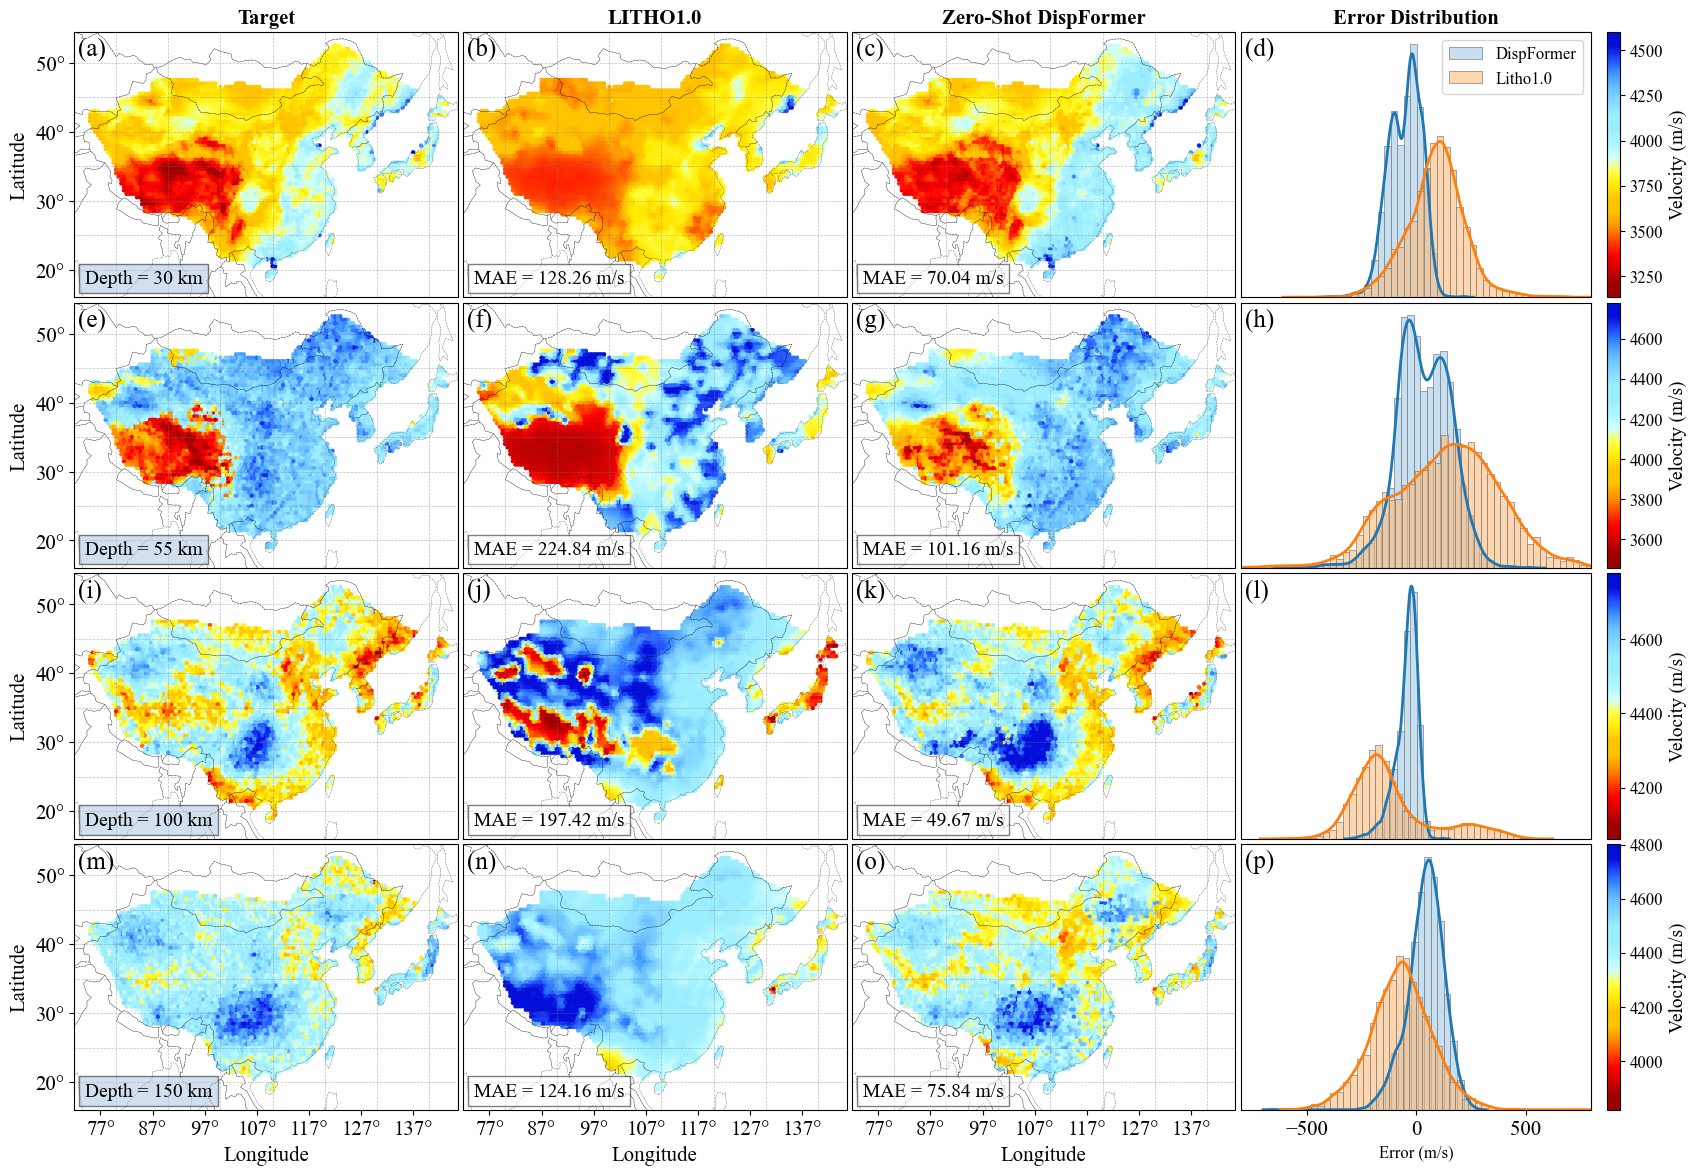

In [28]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import seaborn as sns

# Set the font globally to Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'

# Load custom shapefile for coastlines
custom_shapefile_path ="/ailab/user/liufeng1/project/04_Inversion/SurfWaveInv/DispFormer/DispFormer/plot_source/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shx"
coastline_feature = ShapelyFeature(Reader(custom_shapefile_path).geometries(), ccrs.PlateCarree())

# Create a figure for the scatter plots
fig = plt.figure(figsize=(20,14))

# Create 4 rows of 3 subplots (initially without projections)
axs = fig.subplots(4, 4, gridspec_kw={'height_ratios': [1, 1, 1, 1], 'width_ratios': [1, 1, 1, 1]})

# Get prediction results
target_vs_2016, inv_vs_2016, inputs_disp_2016 = predict_res_transformer(Transformer_loaded_model, criterion, all_shen2016_loader, device=device)


# Define the coordinate systems after creating subplots
for row in range(4):
    axs[row][0].set_axis_off()
    axs[row][1].set_axis_off()
    axs[row][2].set_axis_off()
    axs[row][3].set_axis_off()
    axs[row, 0] = fig.add_subplot(4, 4, row*4 + 1, projection=ccrs.PlateCarree())
    axs[row, 1] = fig.add_subplot(4, 4, row*4 + 2, projection=ccrs.PlateCarree())
    axs[row, 2] = fig.add_subplot(4, 4, row*4 + 3, projection=ccrs.PlateCarree())
    axs[row, 3] = fig.add_subplot(4, 4, row*4 + 4)  # No projection for the histogram

def plot_rows(axs, row, depth_idx, last_row=False):
    vmin = np.min(target_vs_2016[:, 1, depth_idx] * 1000)
    vmax = np.max(target_vs_2016[:, 1, depth_idx] * 1000)
    
    # Scatter plots for target and inverted velocities
    sc_target  = axs[row][0].scatter(all_shen2016_disp_loc[:, 0], all_shen2016_disp_loc[:, 1],
                        c=target_vs_2016[:, 1, depth_idx] * 1000, cmap=cmap, s=10, vmin=vmin, vmax=vmax, edgecolor='None', alpha=1)
    litho1_init= axs[row][1].scatter(all_shen2016_disp_loc[:, 0], all_shen2016_disp_loc[:, 1],
                        c=Shen2016_interpolated_vs[:, depth_idx] * 1000, cmap=cmap, s=10, vmin=vmin, vmax=vmax, edgecolor='None', alpha=1)
    sc_inv     = axs[row][2].scatter(all_shen2016_disp_loc[:, 0], all_shen2016_disp_loc[:, 1],
                        c=inv_vs_2016[:, depth_idx] * 1000, cmap=cmap, s=10, vmin=vmin, vmax=vmax, edgecolor='None', alpha=1)

    # Add longitude/latitude gridline and coastline feature
    for ax in axs[row][:3]:
        gl0 = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl0.top_labels      = False  # Disable top labels
        gl0.right_labels    = False  # Disable right labels
        gl0.left_labels     = False
        gl0.bottom_labels   = False
        gl0.xlabel_style    = {'size': 10, 'color': 'black'}  # Customize label style
        gl0.ylabel_style    = {'size': 10, 'color': 'black'}  # Customize label style
        
        ax.add_feature(coastline_feature, edgecolor='black', facecolor='None', linewidth=0.2, linestyle='-.')
        
        # Set extent for automatic ticks
        extent = [all_shen2016_disp_loc[:, 0].min() - 3, all_shen2016_disp_loc[:, 0].max() + 2,
                  all_shen2016_disp_loc[:, 1].min() - 3, all_shen2016_disp_loc[:, 1].max() + 2]
        ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Annotation for depth
    axs[row][0].annotate(f"Depth = {int(depth_idx * 0.5)} km",
                         xy=(all_shen2016_disp_loc[:, 0].min()-1, all_shen2016_disp_loc[:, 1].min()-1),
                         xycoords='data', fontsize=14, color='black',
                         bbox=dict(facecolor='#A7C0DE', alpha=0.5, edgecolor='black'))
    
    # Compute MAE and annotate
    mae = np.mean(np.abs(target_vs_2016[:, 1, depth_idx] - Shen2016_interpolated_vs[:, depth_idx])) * 1000  # Convert to km
    axs[row][1].annotate(f"MAE = {mae:.2f} m/s",
                         xy=(all_shen2016_disp_loc[:, 0].min()-1, all_shen2016_disp_loc[:, 1].min()-1),
                         xycoords='data', fontsize=14, color='black',
                         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
    
    # Compute MAE and annotate
    mae = np.mean(np.abs(target_vs_2016[:, 1, depth_idx] - inv_vs_2016[:, depth_idx])) * 1000  # Convert to km
    axs[row][2].annotate(f"MAE = {mae:.2f} m/s",
                         xy=(all_shen2016_disp_loc[:, 0].min()-1, all_shen2016_disp_loc[:, 1].min()-1),
                         xycoords='data', fontsize=14, color='black',
                         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))


    # Set latitude and longitude ticks
    x_ticks_begin_shift = 2
    y_ticks_begin_shift = 1
    x_ticks_interval = 10
    y_ticks_interval = 10

    axs[row][0].set_yticks(np.arange(np.floor(all_shen2016_disp_loc[:, 1].min()) + y_ticks_begin_shift,
                                      np.ceil(all_shen2016_disp_loc[:, 1].max()) + 1, y_ticks_interval),
                                    crs=ccrs.PlateCarree())
    axs[row][0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))

    if last_row:
        for ax in axs[row][:3]:
            ax.set_xticks(np.arange(np.floor(all_shen2016_disp_loc[:, 0].min()) + x_ticks_begin_shift,
                                    np.ceil(all_shen2016_disp_loc[:, 0].max()), x_ticks_interval),
                                    crs=ccrs.PlateCarree())
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
            ax.set_xlabel("Longitude", fontsize=15)
    axs[row][0].set_ylabel("Latitude", fontsize=15)
    for ax in axs[row][:3]:
        ax.set_aspect('auto')
    
    for ax in axs[row]:
        ax.tick_params(labelsize=15)

    ###############################################################################################################
    # Calculate absolute errors
    errors_inv = (target_vs_2016[:, 1, depth_idx] - inv_vs_2016[:, depth_idx]) * 1000

    # Set bin width
    bin_width = 30
    inv_bins = np.arange(min(errors_inv), max(errors_inv) + bin_width, bin_width)

    # Plot histogram for INV errors
    sns.histplot(errors_inv, bins=inv_bins, color='#A0CBE8', kde=False, ax=axs[row][3], stat="density", 
                alpha=0.6, edgecolor='gray', linewidth=0.5, label="DispFormer")  # Lighter blue for histogram
                
    # Plot KDE for INV errors
    kdeplot_inv = sns.kdeplot(errors_inv, color='#1F77B4', ax=axs[row][3], lw=2)  # Darker blue for KDE

    # Calculate absolute errors for LITHO1
    errors_lithos = (target_vs_2016[:, 1, depth_idx] - Shen2016_interpolated_vs[:, depth_idx]) * 1000
    litho1_bins = np.arange(min(errors_lithos), max(errors_lithos) + bin_width, bin_width)

    # Plot histogram for LITHO1 errors
    sns.histplot(errors_lithos, bins=litho1_bins, color='#FFBB78', kde=False, ax=axs[row][3], stat="density", 
                alpha=0.6, edgecolor='gray', linewidth=0.5, label="Litho1.0")  # Light gray for histogram

    # Plot KDE for LITHO1 errors
    kdeplot_litho1 = sns.kdeplot(errors_lithos, color='#FF7F0E', ax=axs[row][3], lw=2)  # Darker orange for KDE

    # Set limits and labels for the plot
    axs[row][3].set_xlim([-800, 800])
    if last_row:
        axs[row][3].set_xlabel('Error (m/s)')
    else:
        axs[row][3].set_xticks([])

    # Simplify legend to show only mean and std
    if row == 0:
        axs[row][3].legend(loc='upper right', fontsize=12)
    axs[row][3].set_yticks([])
    axs[row][3].set_ylabel("")
    
    ###############################################################################################################
    # Add vertical colorbar for the scatter plot on axs[row][0]
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for creating colorbar
    # Colorbar on the right of axs[row][0]
    cbar = plt.colorbar(sm, ax=axs[row][3], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Velocity (m/s)', fontsize=14)
    return axs

# Plot for different depths
plot_rows(axs, 0, 60)
plot_rows(axs, 1, 110)
plot_rows(axs, 2, 200)
plot_rows(axs, 3, 300, last_row=True)
    
# Set titles for each column
axs[0][0].set_title('Target'                , fontsize=15, fontweight='bold')
axs[0][1].set_title('LITHO1.0'              , fontsize=15, fontweight='bold')
axs[0][2].set_title('Zero-Shot DispFormer'  , fontsize=15, fontweight='bold')
axs[0][3].set_title('Error Distribution'    , fontsize=15, fontweight='bold')

labels_title = ["(a)","(b)","(c)","(d)",
                "(e)","(f)","(g)","(h)",
                "(i)","(j)","(k)","(l)",
                "(m)","(n)","(o)","(p)"]
for i in range(4):
    for j in range(4):
        axs[i][j].text(0.01, 0.98, labels_title[i*4+j], transform=axs[i][j].transAxes, fontsize=18, fontweight='normal', va='top', ha='left', color='black',font='Times New Roman')

# Adjust layout
plt.subplots_adjust(hspace=0.02, wspace=0.015)
plt.savefig(os.path.join(plot_base_path,"Pretrain_LITHO1_test_Shen2016.png"),bbox_inches="tight",dpi=300)
plt.show()